# Display Examples

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc
import numpy as np
import os
from keras.models import load_model

from keras.backend.tensorflow_backend import set_session
from utils import *

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.4
set_session(tf.Session(config=config))


Using TensorFlow backend.


In [2]:
print("Chest X-ray / cxr\n")
base_dir = '/projects/steinbac/adversarial_medical_imaging/cxr/'
model = load_model(f'{base_dir}/wb_model.h5')
model.summary()

Chest X-ray / cxr

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
ac

In [3]:

(X_test, cxr_y_test,
 X_test_pgd_wb, X_test_pgd_bb) = getResults(base_dir)

Truth: [[1. 0.]]
Model predict on true image: [[0.9975188  0.00248129]]
Model predict on adversarial image: [[2.3234296e-11 1.0000000e+00]]
Model predict on BB adversarial image: [[0.02201507 0.9779849 ]]

True Image Deprocessed:


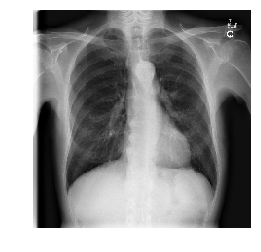

Adversarial Image Deprocessed:


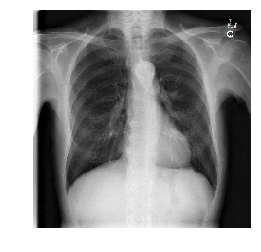

Perturbation*20:


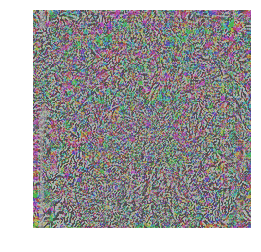

Truth: [[0. 1.]]
Model predict on true image: [[0.20693658 0.79306346]]
Model predict on adversarial image: [[1.0000000e+00 1.0546123e-11]]
Model predict on BB adversarial image: [[0.9799586  0.02004148]]

True Image Deprocessed:


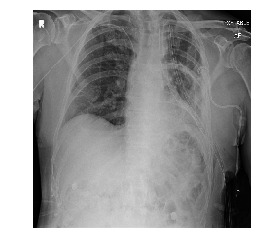

Adversarial Image Deprocessed:


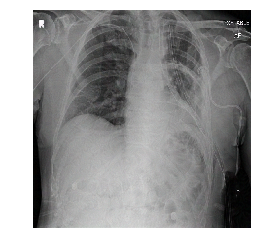

Perturbation*20:


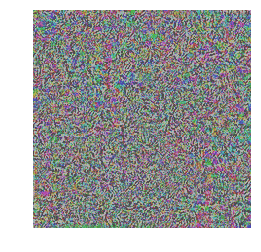

In [4]:
display_adv_examples(2, X_test_pgd_wb, model, X_test, cxr_y_test, verbose = True, X_test_bb = X_test_pgd_bb)
display_adv_examples(8378, X_test_pgd_wb, model, X_test, cxr_y_test, verbose = True, X_test_bb = X_test_pgd_bb)

In [5]:

import foolbox
from foolbox.models import KerasModel
from foolbox.attacks import LBFGSAttack
from foolbox.criteria import TargetClassProbability

fmodel = KerasModel(model, bounds=(-1., 1.))

# run the attack
#attack = LBFGSAttack(model=fmodel, criterion=TargetClassProbability(1, p=.7))
#attack  = foolbox.attacks.FGSM(fmodel)
#attack = foolbox.attacks.SaltAndPepperNoiseAttack(model=fmodel, criterion=TargetClassProbability(1, p=.5))

attack = foolbox.attacks.LBFGSAttack(model=fmodel, criterion=TargetClassProbability(1, p=.5))
image = np.asarray(X_test[1:2,...])
print(f"image of {image.shape} loaded")

kpred = model.predict(image)
print(f"model.predict labels of {np.argmax(kpred)} ({kpred}, {kpred.shape})")

pred  = fmodel.predictions(image[0])
label = np.argmax(pred)
print(f"fmodel.predictions labels of {label} {label.shape} ({pred}, {pred.shape})")


image of (1, 224, 224, 3) loaded
model.predict labels of 0 ([[0.99802065 0.00197934]], (1, 2))
fmodel.predictions labels of 0 () ([ 3.9993238 -2.223685 ], (2,))


In [6]:
print("min,max,mean,sd",np.max(image),np.min(image),np.mean(image),np.std(image) )
adversarial = attack( image[0] , label)                 

min,max,mean,sd 0.9529412 -0.94509804 0.3523391 0.46226245


1 0
True Image Deprocessed:


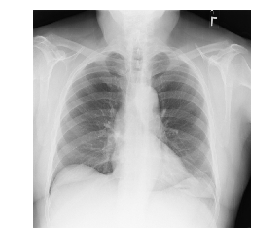

Adversarial Image Deprocessed:


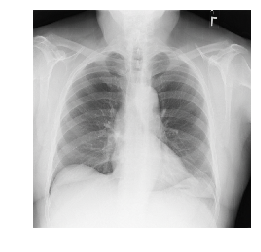

Perturbation*20:


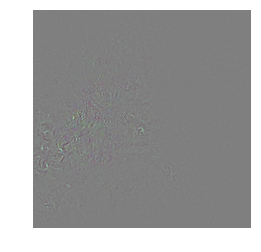

(array([     5,     43,    326,   8019, 140490,   1466,    144,     25,
            5,      5]), array([-0.01935128, -0.01481983, -0.01028838, -0.00575693, -0.00122548,
        0.00330597,  0.00783742,  0.01236888,  0.01690033,  0.02143178,
        0.02596323], dtype=float32))


In [7]:
## print(adversarial.shape)
if not isinstance(adversarial, type(None)):
    print(np.argmax(fmodel.predictions(adversarial)), label)

plot_to_compare(image[0], adversarial)

In [8]:
attack2 = foolbox.attacks.SpatialAttack(model=fmodel, criterion=TargetClassProbability(1, p=.5))
image = np.asarray(X_test[1:2,...])
print(f"image of {image.shape} loaded")

kpred = model.predict(image)
print(f"model.predict labels of {np.argmax(kpred)} ({kpred}, {kpred.shape})")

pred  = fmodel.predictions(image[0])
label = np.argmax(pred)
print(f"fmodel.predictions labels of {label} {label.shape} ({pred}, {pred.shape})")


image of (1, 224, 224, 3) loaded
model.predict labels of 0 ([[0.99802065 0.00197934]], (1, 2))
fmodel.predictions labels of 0 () ([ 3.9993238 -2.223685 ], (2,))


In [ ]:
adversarial2 = attack2( image[0] , label)
if not isinstance(adversarial2, type(None)):
    print(np.argmax(fmodel.predictions(adversarial)), label)
    plot_to_compare(image[0], adversarial)
else:
    print('attack2 didn\'t find an adversarial example')

# Toy Model Confidence Plots

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def confidence_plot(preds = [0.93706179, 0.06293821],
                  labels = ["Pneumothorax", "Normal"],
                   isNormal = True, hideText = False,
                   diseaseTop = False):
    sns.set(font_scale=2)

    if isNormal:
        pal = ["red", "green"]
    else:
        pal = ["green", "red"]
        
    if not diseaseTop:
        preds.reverse()
        pal.reverse()
        labels.reverse()
        
    d = {'Model Confidence' : pd.Series(preds, index=['a', 'b']),
         'Diagnosis' : pd.Series(labels, index=['a', 'b'])}
    ax = sns.barplot(x="Model Confidence", y="Diagnosis",
                     data=pd.DataFrame(d), palette=pal)
    ax.set_xlim((0,1))
    ax.set_ylabel('') 
    if hideText:
        ax.set_yticklabels(['',''])
        ax.set_xlabel('')
        ax.set_xticklabels('')
    plt.show()

### Generate plots

In [ ]:
hide_diag = False
confidence_plot([ 0.00930259, 0.9906974],
               ["Malignant", "Benign"],
               isNormal = True, hideText = hide_diag)

confidence_plot([1.0000000e+00, 2.2059932e-11],
               ["Malignant", "Benign"],
               isNormal = True, hideText = hide_diag)

In [ ]:
hide_diag = False
confidence_plot([ 0.048, 1 - 0.048],
               ["Diabetic \nRetinopathy", "Healthy"],
               isNormal = True, hideText = hide_diag)

confidence_plot([1.0000000e+00, 2.2059932e-11],
               ["Diabetic \nRetinopathy", "Healthy"],
               isNormal = True, hideText = hide_diag)

# ROC, Sensitivity, Specificity

## Load Model Output

In [ ]:
import numpy as np
import os
os.chdir('/home/sgf2/DBMI_server/adversarial_attacks/')

y_test_dr = np.load('retinopathy/data/val_test_y.npy')
preds_dr = np.load('retinopathy/data/winning_model_preds.npy') #from model 30 epochs is best right now
print((preds_dr.shape, y_test_dr.shape))

y_test_cxr = np.load('cxr/data/val_test_y.npy')
preds_cxr = np.load('cxr/data/winning_model_preds.npy')
print((y_test_cxr.shape, preds_cxr.shape))

y_test_derm = np.load('melanoma/data/val_test_y.npy')
preds_derm = np.load('melanoma/data/winning_model_preds.npy')
print((preds_derm.shape, y_test_derm.shape))

## Plot Roc

In [ ]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc

# Generate roc curves from lists of: predictions, labels, and titles
def plot_roc(preds_list, y_test_list ,
             curve_titles_list = None,
             mainTitle = 'Receiver operating characteristic curve'):
    
    # If input is not list, convert it to a list
    if type(preds_list) is not list:
        preds_list = [preds_list]
        y_test_list = [y_test_list]
        if curve_titles_list is not None:
            curve_titles_list = [curve_titles_list]
        
    assert len(preds_list) == len(y_test_list), "Must provide same number of preds and labels."
    
    # Set up figure of size 5x5
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 5
    fig_size[1] = 5
    plt.rcParams["figure.figsize"] = fig_size
        
    # Cycle through lists of predictions and labels and generate roc curves
    for preds, y_test, curve_title in zip(preds_list, y_test_list, curve_titles_list):
        fpr, tpr, thresholds = metrics.roc_curve(y_test[:,1], preds[:,1])
        auc_score = auc(fpr,tpr)
        curve_label = curve_title + ' (AUC=%0.2f)' % float(auc_score)
        if len(preds_list) == 1:
            plt.plot(fpr,tpr,label= curve_label, color="darkorange")
        else:
            plt.plot(fpr,tpr,label= curve_label)
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
   
    # Set axes and titles
    plt.xlim([0, 1.0])
    plt.ylim([0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(mainTitle)
    plt.legend(loc="lower right")
    
    # Display
    plt.show()

plot_roc([preds_dr, preds_cxr, preds_derm],
         [y_test_dr, y_test_cxr, y_test_derm],
         ['Retinopathy', 'Pneumothorax', 'Melanoma'],
         "Performance of baseline diagnostic models")

#plot_roc(preds_dr,
#         y_test_dr,
#         'Retinopathy',
#         "Performance of baseline diagnostic models")

### DR

In [ ]:
# Recall of positive class is sensitivity, recall of negative class is spec
from sklearn.metrics import classification_report
print("DR performance:")
print(classification_report(y_test_dr[:,1], (preds_dr[:,1] > 0.14) ))

### CXR

In [ ]:
print("CXR performance:")
print(classification_report(y_test_cxr[:,1], (preds_cxr[:,1] > 0.025)))

### Derm

In [ ]:
print("Derm performance:")
print(classification_report(y_test_derm[:,1],  (preds_derm[:,1] > 0.02)))